# Download data from TCGA 

Since they only provided the normalised values, we wanted to download the counts data and add in the clinical information.
https://www.sciencedirect.com/science/article/pii/S0092867419311237
https://cptac-data-portal.georgetown.edu/study-summary/S050

They only provided the RPKm so I had to go and download the raw counts from GDC directly:
https://portal.gdc.cancer.gov/repository?filters=%7B%22op%22%3A%22and%22%2C%22content%22%3A%5B%7B%22op%22%3A%22in%22%2C%22content%22%3A%7B%22field%22%3A%22cases.primary_site%22%2C%22value%22%3A%5B%22kidney%22%5D%7D%7D%2C%7B%22op%22%3A%22in%22%2C%22content%22%3A%7B%22field%22%3A%22cases.project.project_id%22%2C%22value%22%3A%5B%22CPTAC-3%22%5D%7D%7D%2C%7B%22op%22%3A%22in%22%2C%22content%22%3A%7B%22field%22%3A%22files.analysis.workflow_type%22%2C%22value%22%3A%5B%22HTSeq%20-%20Counts%22%5D%7D%7D%2C%7B%22op%22%3A%22in%22%2C%22content%22%3A%7B%22field%22%3A%22files.data_type%22%2C%22value%22%3A%5B%22Gene%20Expression%20Quantification%22%5D%7D%7D%5D%7D&searchTableTab=cases

Here I selected HTseq counts for the patients from the CPTAC RCC study.

```

sb = SciBiomartApi()
results_df = sb.get_human_default(attr_list=['entrezgene_id'])
# Now let's sort it
results_df = sb.sort_df_on_starts(results_df)
print(results_df.values)
sb.save_as_csv(results_df, 'data/supps/')
```


In [1]:
# Now we need to download the data from TCGA for the RNAseq
from scidat.api import API, APIException
from sciutil import SciUtil
import pandas as pd

u = SciUtil()
save_fig = False

In [2]:
base_dir = '../data/raw_downloads/TCGA/'
supp_dir = '../data/raw_downloads/supps/'
output_dir = f'../data/sircle/F1_DE_input_TvN/'
fig_dir = '../figures/'
data_dir = f'{base_dir}TCGA_RNA/'

annotation_file = f'{supp_dir}hsapiens_gene_ensembl-GRCh38.p13_external_synonym.csv'

gene_name = 'hgnc_symbol'
gdc_client = f'{data_dir}./gdc-client'
sample_file = f'{data_dir}gdc_sample_sheet.2021-05-03.tsv'
manifest_file = f'{data_dir}gdc_manifest_20210503_065756.txt'
clinical_file = f'{data_dir}clinical.cart.2021-05-03/clinical.tsv'

api = API(manifest_file, gdc_client, clinical_file, sample_file, data_dir, data_dir, annotation_file,
                            max_cnt=10, requires_lst=['counts'])

"""
If you haven't downloaded the data already you'll need to do this step!
""" 

download_rnaseq = False
if download_rnaseq:
    api.download_data_from_manifest()

/Users/ariane/opt/miniconda3/envs/clean_ml/lib/python3.6/site-packages/IPython/core/interactiveshell.py:3263: DtypeWarning: Columns (2) have mixed types.Specify dtype option on import or set low_memory=False.
  if (await self.run_code(code, result,  async_=asy)):


## Filter annotation file to just include minimal mappings between external gene names

In [3]:
import numpy as np
annotation_df = pd.read_csv(annotation_file)
# Fill NA's to make the smallest entrez gene IDs be the first.
annotation_df['entrezgene_id'] = annotation_df['entrezgene_id'].fillna(value=100000000000000000)
annotation_df = annotation_df.loc[annotation_df.groupby('ensembl_gene_id').entrezgene_id.idxmin()] # We just remove the duplicates
# Replace the same number with NaN
annotation_df['entrezgene_id'] = annotation_df['entrezgene_id'].replace(100000000000000000, np.nan)
# Remove
annotation_df.sort_index(ascending=True)
# Save as CSV for everything else
annotation_df.to_csv(f'{supp_dir}hsapiens_gene_ensembl-GRCh38.p13.csv', index=False)
annotation_file = f'{supp_dir}hsapiens_gene_ensembl-GRCh38.p13.csv'
annotation_df

/Users/ariane/opt/miniconda3/envs/clean_ml/lib/python3.6/site-packages/IPython/core/interactiveshell.py:3072: DtypeWarning: Columns (2) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


,ensembl_gene_id,external_gene_name,chromosome_name,start_position,end_position,strand,entrezgene_id,external_synonym,hgnc_symbol
104394,ENSG00000000003,TSPAN6,X,100627108,100639991,-1,7105.0,T245,TSPAN6
104389,ENSG00000000005,TNMD,X,100584936,100599885,1,64102.0,BRICD4,TNMD
54163,ENSG00000000419,DPM1,20,50934867,50959140,-1,8813.0,CDGIE,DPM1
6100,ENSG00000000457,SCYL3,1,169849631,169894267,-1,57147.0,PACE-1,SCYL3
6079,ENSG00000000460,C1orf112,1,169662007,169854080,1,55732.0,FLJ10706,C1orf112
...,...,...,...,...,...,...,...,...,...
31798,ENSG00000289640,NaN,16,21116439,21121291,1,NaN,NaN,NaN
61295,ENSG00000289641,NaN,3,127227404,127231028,1,NaN,NaN,NaN
4650,ENSG00000289642,NaN,1,149013782,149014961,1,NaN,NaN,NaN
64035,ENSG00000289643,NaN,4,42285823,42292644,-1,NaN,NaN,NaN


## Build RNAseq df using scidat

In [4]:

## Once the data is downlaoded we can build the RNAdf
# Now we want to first build the annotation
api.build_annotation()
api.build_rna_df()
df = api.get_rna_df()

# Drop rows that aren't genes
df_filtered = df[df['id'].str.contains('ENSG')]
df.to_csv(f'{output_dir}CCRCC_Clark_Cell2019_rna_df.csv')


--------------------------------------------------------------------------------
 Run: annotate.set_case_submitter_id() to setup. 
Continuing with automatic selection.	
--------------------------------------------------------------------------------
--------------------------------------------------------------------------------
                    Submitter ID set as: 	case_submitter_id	                    
--------------------------------------------------------------------------------
--------------------------------------------------------------------------------
                              Clinical dataframe	                               
--------------------------------------------------------------------------------
--------------------------------------------------------------------------------
  case_submitter_id project_id age_at_index  gender          race  \
0         C3N-01175    CPTAC-3          '--  female  not reported   
1         C3L-00010    CPTAC-3          '--  

## QC check correlations between the samples

Here we just want to do some very basic comparisons between patients, basically just filtering out any with very poor correlation.

/Users/ariane/opt/miniconda3/envs/clean_ml/lib/python3.6/site-packages/seaborn/matrix.py:649: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)
/Users/ariane/opt/miniconda3/envs/clean_ml/lib/python3.6/site-packages/seaborn/matrix.py:1205: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 
  self.fig.tight_layout(**tight_params)


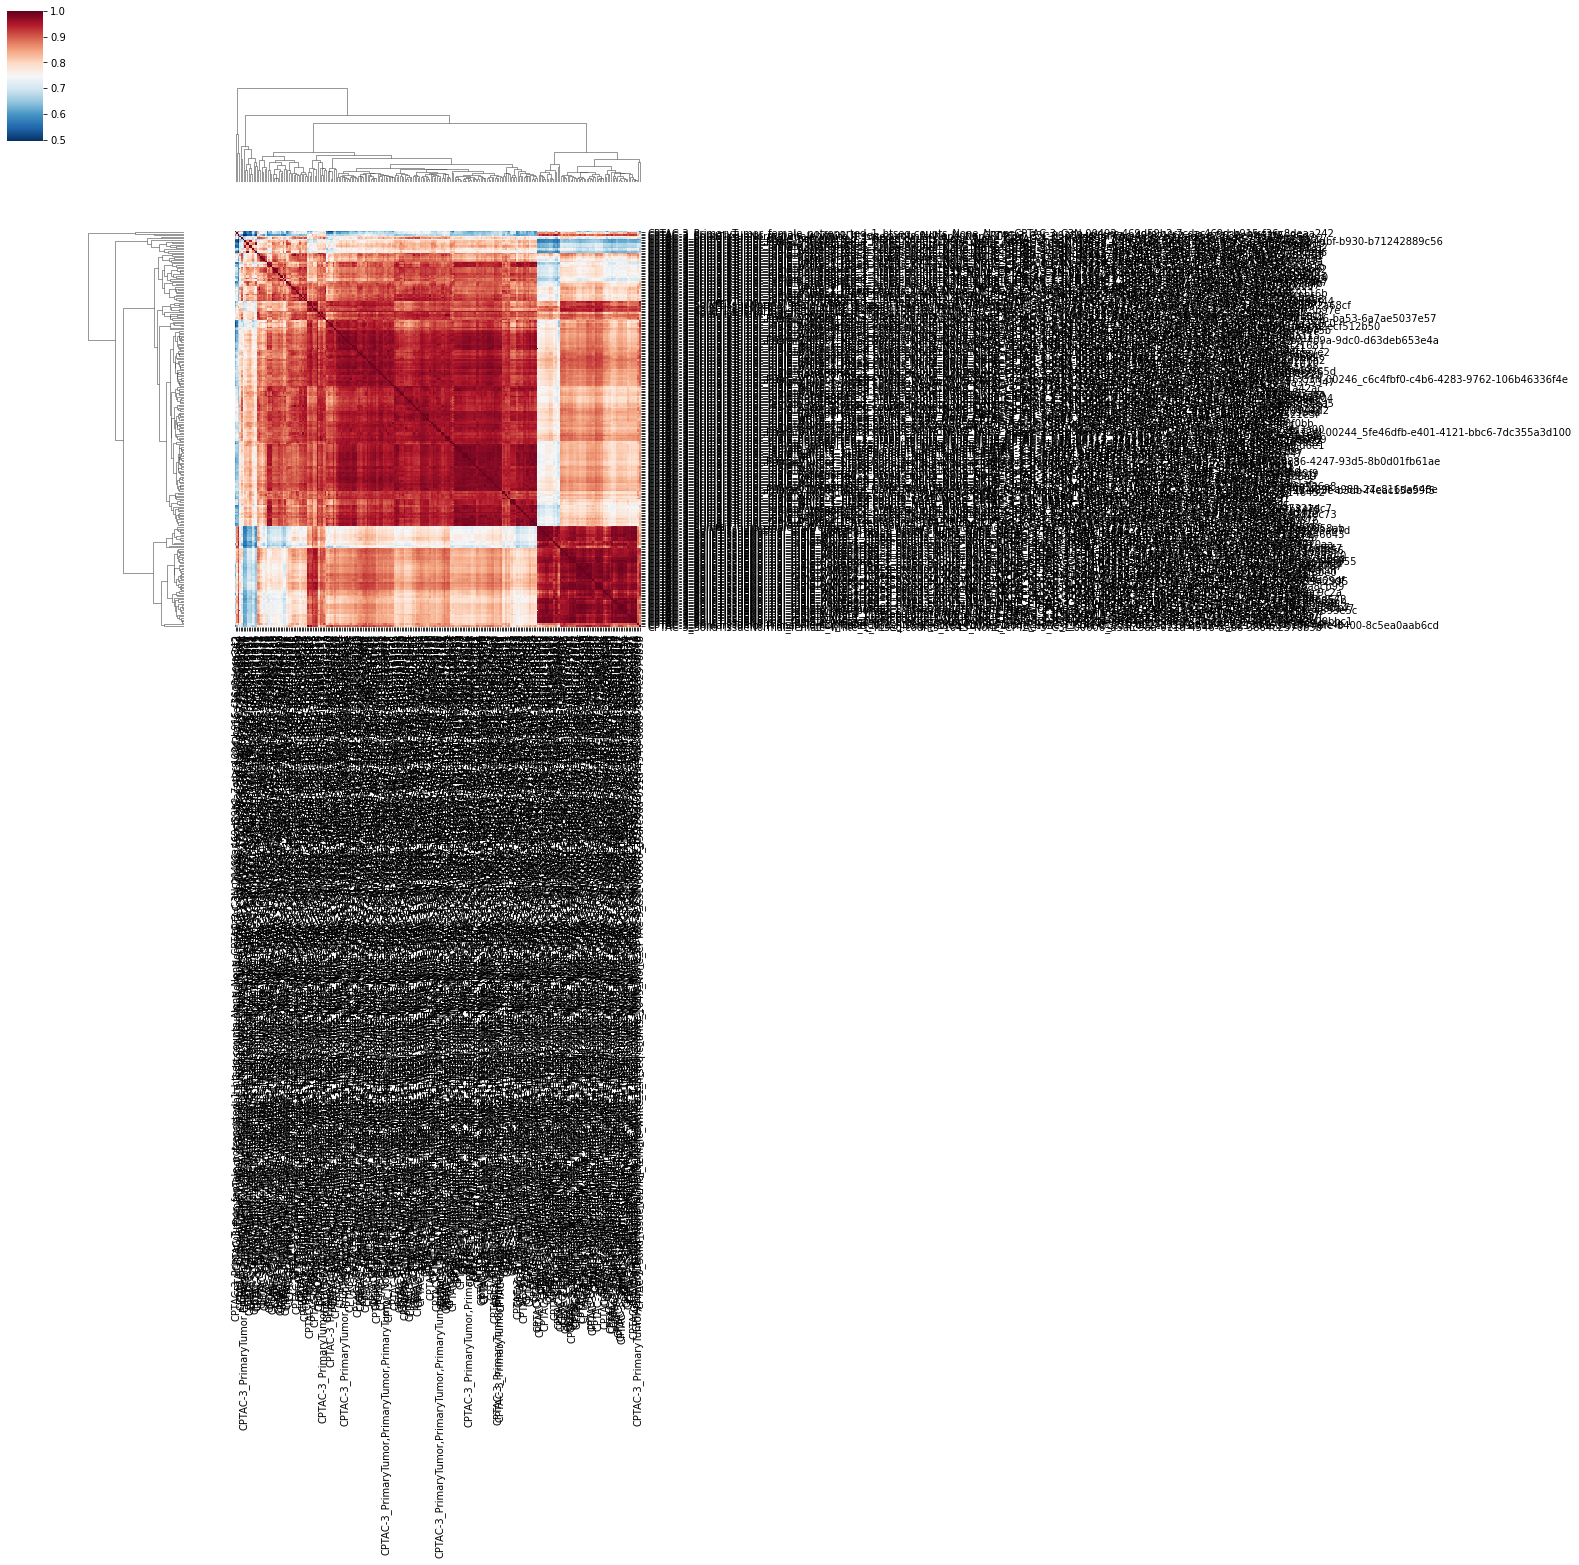

In [5]:
import seaborn as sns
import matplotlib.pyplot as plt

# Check the correlation between samples
all_cases = [c for c in df_filtered.columns if 'CPTAC' in c]
corr = df_filtered[all_cases].corr()
sns.clustermap(corr, 
            xticklabels=corr.columns.values,
            yticklabels=corr.columns.values, cmap='RdBu_r', row_cluster=True, col_cluster=True)
if save_fig:
    plt.savefig(f'{fig_dir}Heatmap_RNAseq.svg')

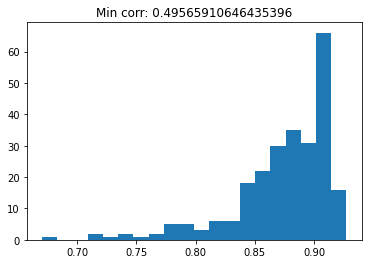

--------------------------------------------------------------------------------
6	patients with avg. correlations less than 75. Filtering out these samples, and printing cases.	
--------------------------------------------------------------------------------
C3N-00492
C3N-01648,C3N-01648
C3L-00359
C3L-00448
C3N-01200
C3N-00315
['CPTAC-3_PrimaryTumor_female_notreported_1_htseq.counts_None_None_CPTAC-3_C3N-00492_469d59b2-7cda-469d-b915-f36c8deaa242', 'CPTAC-3_PrimaryTumor,PrimaryTumor_None_None_None_htseq.counts_None_None_CPTAC-3_C3N-01648,C3N-01648_a5aa7a66-eb32-4dbf-b930-b71242889c56', 'CPTAC-3_PrimaryTumor_female_white_1_htseq.counts_None_None_CPTAC-3_C3L-00359_cf8af8ac-49f8-40f2-a16e-5630e0ff62f2', 'CPTAC-3_SolidTissueNormal_male_white_1_htseq.counts_None_None_CPTAC-3_C3L-00448_4f77ce4c-e7cd-4aa0-8776-bd103f2b686d', 'CPTAC-3_PrimaryTumor_female_notreported_1_htseq.counts_47_None_CPTAC-3_C3N-01200_3a7e5a81-a316-4e73-8286-001d623d5709', 'CPTAC-3_PrimaryTumor_male_notreported_1_htseq.c

In [6]:
import numpy as np

all_cases = [c for c in df_filtered.columns if 'CPTAC' in c]
corr = df_filtered[all_cases].corr()
# Print out the minimum correlation:
min_corr = min(np.min(corr))
# Since 50% correlation is pretty low, let's see which cases they are and probably remove them 
# from the RNAseq (since it looks like there are 3 outliers.)
mean_cor = np.mean(corr, axis=1)
corr['mean_corr'] = mean_cor
corr.sort_values(by=['mean_corr'])
# Plot out the mean correlation values so we can choose a good filter.
plt.hist(mean_cor, bins=20)
plt.title(f'Min corr: {min_corr}')
if save_fig:
    plt.savefig(f'{fig_dir}Hist_RNAseq.svg')
plt.show()

# Sort again and this time filter
corr_sorted = corr.sort_values(by=['mean_corr'])
corr_sorted = corr_sorted[corr_sorted['mean_corr'] < 0.75]
u.dp([len(corr_sorted), 'patients with avg. correlations less than 75. Filtering out these samples, and printing cases.'])

cols_to_omit = [c for c in corr_sorted.index if 'CP' in c]
case_ids = [c.split('_')[-2] for c in corr_sorted.index if 'CP' in c]
print('\n'.join(case_ids))
print(cols_to_omit)

## Filter samples

Find which samples had the poor correlation and remove these

/Users/ariane/opt/miniconda3/envs/clean_ml/lib/python3.6/site-packages/seaborn/matrix.py:649: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)
/Users/ariane/opt/miniconda3/envs/clean_ml/lib/python3.6/site-packages/seaborn/matrix.py:1205: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 
  self.fig.tight_layout(**tight_params)


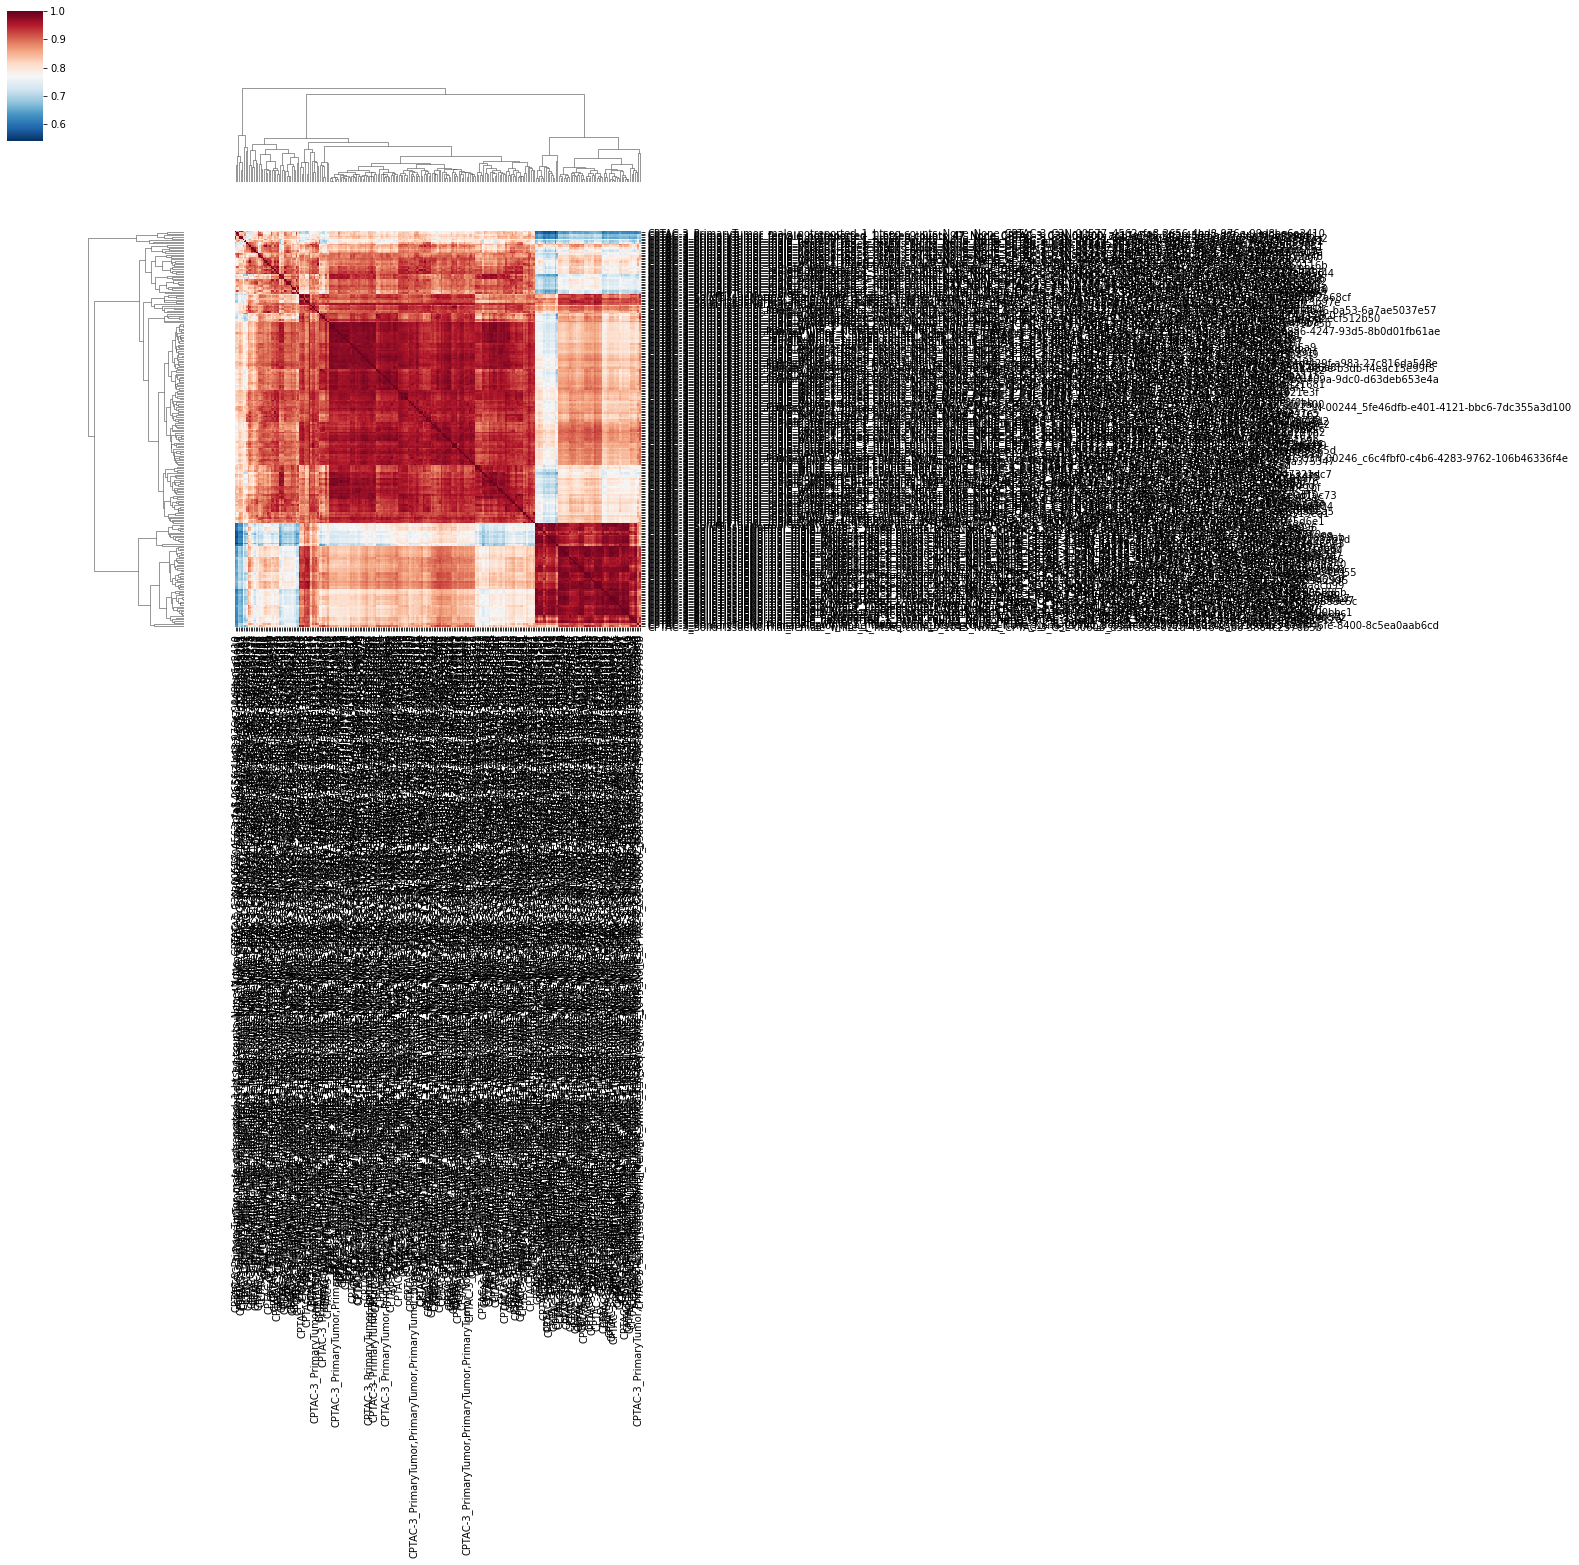

In [7]:
cols_to_keep = [c for c in df_filtered.columns if c not in cols_to_omit]
corr = df_filtered[cols_to_keep].corr()
sns.clustermap(corr, 
            xticklabels=corr.columns.values, figsize=(30, 30),
            yticklabels=corr.columns.values, cmap='RdBu_r', row_cluster=True, col_cluster=True)
if save_fig:
    plt.savefig(f'{fig_dir}Heatmap_RNAseq_removed_corr-leq-0.75.svg')

In [8]:
# Actually remove those columns! (But make sure you keep the ID column)
df_filtered = df_filtered[cols_to_keep]
# Print out the minimum correlation:
min(np.min(corr))
# Since 50% correlation is pretty low, let's see which cases they are and probably remove them 
# from the RNAseq (since it looks like there are 3 outliers.)

0.5420264228833744

## Add in the gene names and entrez IDs
We also want to add in gene name and also add in the entrez IDs etc do this from HG 38 since this is what it was mapped to from the paper: https://www.sciencedirect.com/science/article/pii/S0092867419311237

```
Total RNA Sequencing
Indexed RNA-seq libraries were sequenced using the HiSeq4000 platform to generate a minimum of 120 million paired end reads (75 base pairs) per library with a target of greater than 90% mapped reads. The sequence data were demultiplexed and converted to FASTQ files, and adaptor and low-quality sequences were quantified/trimmed. Samples were then assessed for quality by mapping reads to the hg38 reference genome, estimating the total number of reads that mapped, assessing the amount of RNA that mapped to coding regions, the amount of rRNA in the sample, the number of genes expressed, and the relative expression of housekeeping genes. Samples that passed the quality criteria were then clustered with other expression data from similar and distinct tumor types to confirm expected expression patterns, including pathological status (i.e., normal adjacent versus tumor tissue) and tissue-origin specificity. FASTQ files of all reads were then uploaded to the GDC repository.
```

In [9]:
# add in annotation for gene IDs
import pandas as pd

annot = pd.read_csv(annotation_file)
# Remove the version then merge with our annotation dataframe
ensembl_ids = [e_id.split('.')[0] for e_id in df_filtered['id'].values]
df_filtered['ensembl_gene_id'] = ensembl_ids
print(len(df_filtered))
df_filtered_annot = df_filtered.set_index('ensembl_gene_id').join(annot.set_index("ensembl_gene_id"), how="inner")
# # 54713 for hg19 vs 39743 for hg38
df_filtered_annot = df_filtered_annot.drop_duplicates(subset='id', keep='first')
print(len(df_filtered_annot))
# Save this dataframe as a counts file but first let's re-order so all the columns with metadata are 
# at the start
meta_cols = [c for c in df_filtered_annot if 'CPTAC' not in c]
cols = [c for c in df_filtered_annot if 'SolidTissueNormal' in c]
cols += [c for c in df_filtered_annot if 'SolidTissueNormal' not in c and 'CPTAC' in c]
df_filtered_annot = df_filtered_annot[meta_cols + cols]

60483
56421


In [10]:
df_filtered_annot.to_csv(f'{output_dir}CCRCC_Clark_Cell2019_rna_filtered_df.csv')